This should be comprehensive titanic challange. If you appreciate what I have done please like it :)

**Introduction**
The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Can we predict who will survive based on certain characteristics?
Goal of this Kernel is to give a workflow, and a directions how one should procede when faced with any predictive challenge (not only classification as here).


There are two main steps:
1.  **Data preparation** We need to make sure that the data is in a format understandable to machine learning algorithms. That implies converting the data in numerical form. Not only that we should also think about whether there are some features (independent variables) that can be improved or even derived from existing ones in order to improve predictive power.
2. **Modeling** Here we start using our algorithms. There are couple of thinks that we should bare in mind. Are all pre-processing steps satisfactory (i.e. if I am using k-means clustering I am going to need to scale my data etc.), what are my hyper-parameter values and how can I optimize them (we will see use of randomizedSearch() and GridSearch(). How do I evaluate my accuracy? Did I use cross-validation that ensures "complete data usage" etc.

**NOTE**
As we can see there are a couple of things that we should bare in mind. Ofcourse this list is far from complete but the goal of this kernel is to give a comprehensible start into Kaggle predictive challenges.

In [1]:
#Necessary packages
import numpy as np #linear Algebra
import pandas as pd #data manipulation
import seaborn as sns #multiple plots
import matplotlib.pyplot as plt #plotting
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline 

train_df=pd.read_csv("../input/train.csv")
test_df=pd.read_csv("../input/test.csv")

In [2]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.tail()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


Kaggle offers very nice interface to look at the data. Basically what we have here is:


survival Survival 0 = No, 1 = Yes

pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd

sex: Male or Female

Age: Age in years

sibsp: # of siblings / spouses aboard the Titanic

parch: # of parents / children aboard the Titanic

ticket: Ticket number

fare: Passenger fare

cabin: Cabin number

embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

**Missing Values**
Let us define a function that will find the missing values and also plot the frequency of them. With this information we can impute the values accordingly.  OR as in the case of Cabin feature delete it, since imputing does not make much sense.


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


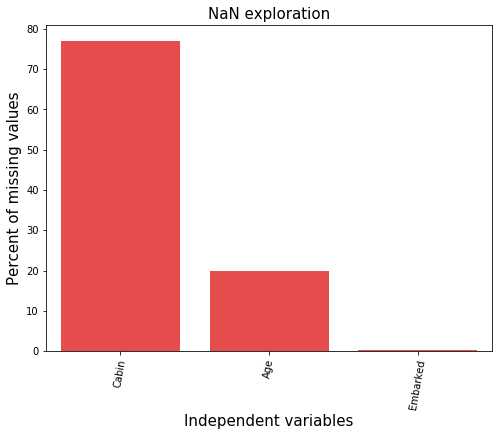

In [4]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Independent variables', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('NaN exploration', fontsize=15)
    return ms

missingdata(train_df)

There is a possibility that test and train datasets do not have sama NaN values, especially if they are small. Let us check:


,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


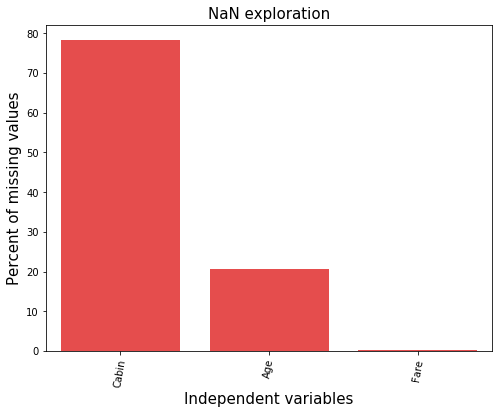

In [5]:
missingdata(test_df)

**Data imputation**

First of all we need to think is it instincitive to do it? For example Cabin variable should be excluded. 
Age variable can be imputed, but which value? First things that come to mind are mean and median imputation. But one should note that they are not automatically correct and that imputing with these two method can lead to more damage than leaving the data untouched. We are going to focus on these two simple method of imputing numerical data, but for more on imputation please consult [](https://en.wikipedia.org/wiki/Imputation_(statistics))


Choosing between mean or median imputation we should look for outliers. If there are signs of them then median is the choice since mean will be heavily affected by them. Depending on the context (and that is general rule!) mean could also be unfavorable because is produces(possibly) value in data set that did not exist beforehand. Let us plot our Age variable

Text(0.5,1,'Variable exporation')

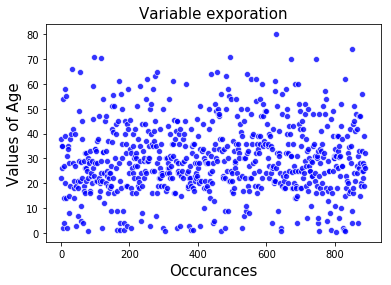

In [6]:
fig=sns.scatterplot(train_df.index, train_df["Age"],color="blue",alpha=0.8)
plt.xlabel('Occurances', fontsize=15)
plt.ylabel('Values of Age', fontsize=15)
plt.title('Variable exporation', fontsize=15)

There are couple of outliers here, we can procede bothways. Here we can learn another lesson regarding modeling. When in doubt try both methods and see what works better.


In [7]:
test_df['Age'].fillna(test_df['Age'].median(), inplace = True)
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)


#For example when trying to exclude the cabin column we are going to receive unnecessary warnings. Exclude! (thats why we imported it)
drop_column = ['Cabin']
train_df.drop(drop_column, axis=1, inplace = True)
test_df.drop(drop_column,axis=1,inplace=True)

test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True)



Fare and Embarked are two columns where test and train differ in missing values. Nevertheless we should impute both of them. Interesting thing is that embarked is a character column. For that we are going to impute with the .mode() method. Basically we impute the column with the single most occuring element in that column.

In [8]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)

Let us check that we do not have anymore missing values and procede with feature engineering.



In [9]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


**Feature engineering**

Question that we should as ourselves is how can I combine&extract additional information&features from the existing ones. Let us us start with character column Namne. We can see that there are some reguarities, i.e. titles like Mrs, Miss etc. are repetative. Surely they can give us some information. We need to extract it. For that we will use re library (regular expression). In a nutshell we just extrapolate the text of interest from a text corpus using regular expressions and synthax in re library. We will be defining a function that does the heavy lifting.


In [10]:
# in order to apply the function only once
all_data=[train_df,test_df]

In [11]:
import re
# A way to think about textual preprocessing is: Given my character column, what are some regularities that occur often. In our case we see titles (miss,mr etc).
# Let us then extract second word from every row and assign it to a new column. Not only that let us make it categorical (so that we can one-hot encode it) where we observe the most frequent ones.


def title_parser(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Check whether title exists, then return it, if not ""
    if title_search:
        return title_search.group(1)
    return ""
# New column named Title, containing the titles of passenger names
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(title_parser)
# Irrelevant titles should be just called irrelevant (in sence that they do not occur often)
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'irrelevant')
# Let us make sure they are categorical, where we replace similiar names
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


Before proceeding let us have a look at how our variables interact with each other. (not the correlation/heat matrix)


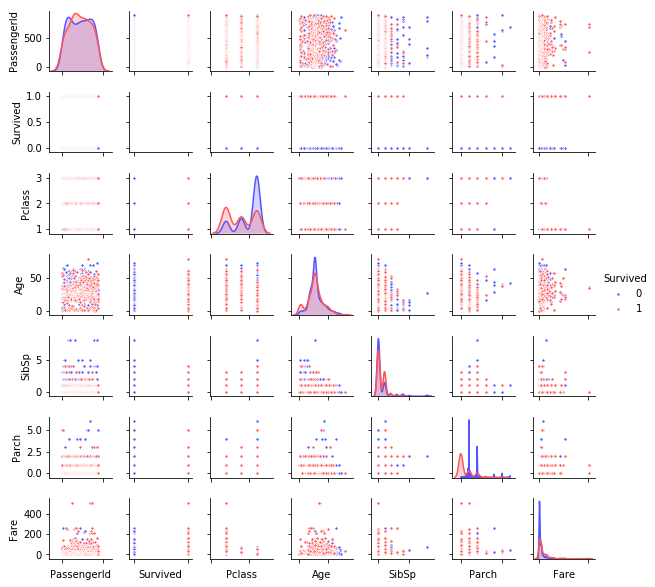

In [12]:
g = sns.pairplot(data=train_df, hue='Survived', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

#as a general rule with classification problems, we will always put the target variable (to be classified) in hue


We are slowly getting our dataset ready. What variables are useless, drop them! and can we create new features?


In [13]:
all_data=[train_df,test_df]

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    ## create bin for age features
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
    
    
  


In [14]:
# create bin for fare features
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

In [15]:
traindf=train_df
testdf=test_df

all_dat=[traindf,testdf]

for dataset in all_dat:
    drop_column = ['Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)
    
   

In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,2,Adult,high_fare
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,1,Adult,median_fare


One hot encoding so that algorithm can understand

In [17]:
traindf = pd.get_dummies(traindf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

testdf = pd.get_dummies(testdf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

traindf.head()
testdf.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_irrelevant,Age_type_Children,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,892,3,34.5,0,0,7.8292,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
1,893,3,47.0,1,0,7.0000,2,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0
2,894,2,62.0,0,0,9.6875,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,895,3,27.0,0,0,8.6625,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
4,896,3,22.0,1,1,12.2875,3,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0


One last thing before we start with modeling. We have a lot of variables, but question is, is there a lot of correlation between them. Because if there is some of them are redundant, i.e. using onge of them is waste of resources. (Highly positive or negative correlated).  In the following we are going to show-case heat-map of correlation, to get a view of the correlation. Pearson correlation gives quantifies the relationships.


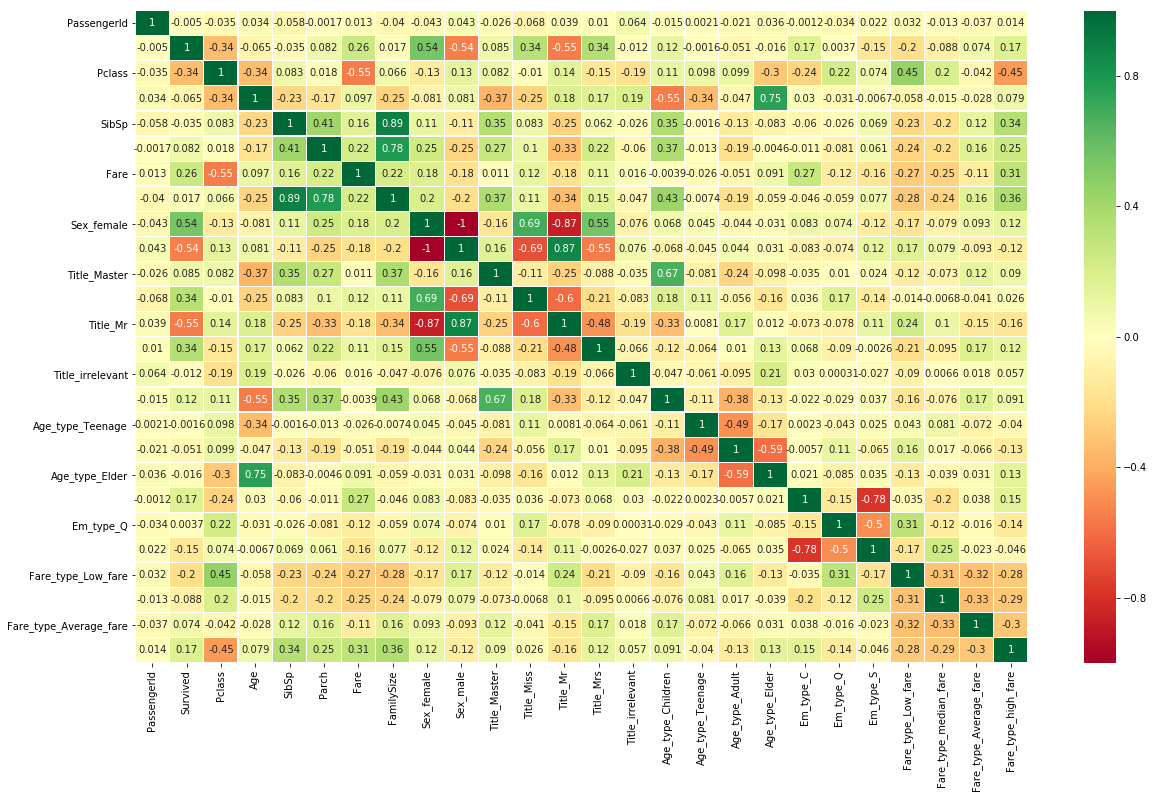

In [18]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

One possibility is to pair all of the varibales that have coefficient larger or smaller than 0.5 and -0.5 respectively. To keep things simple we are going to skip this step.

Finally the really last step is scaling and data-transformation. In other words when dealing with numerical data on scale, certain algortihms do not like the fact that two seprate columns are not on the same unit of measure, furthermore if we are measuring distance (which is the case with for example KNN than scale will greatly influence the results-- because outlier in one scale is nothing compared to outlier on other scale) then it is important to scale the data.  Before we proceede with scaling, let us just say that log-transformation (generally Cox-Box transformation) is not necessary for 2 main reasons: 1. We do not need to assume normality 2. We are not dealing with prices (the whole discussion with multiplicative vs. additive interpretation can be found online.

That is OK, but what do we do with our 2 numerical columns, Age and Fare?


In [19]:
type(traindf["Age"])

pandas.core.series.Series

In [20]:
from sklearn.preprocessing import MinMaxScaler


traindf[['Age','Fare']] = traindf[['Age',"Fare"]].apply(pd.to_numeric)
scaler = MinMaxScaler()
traindf[['Age','Fare']] = scaler.fit_transform(traindf[['Age',"Fare"]])

drop_column = ['PassengerId']#id of any kind will be always dropped since it does not have predictive power
traindf.drop(drop_column, axis=1, inplace = True)
train_X = traindf.drop("Survived", axis=1)#we do not need train test splitting with skicit learn (in nomral setting test_df and train_df will be concatanted and then use it)
train_Y=traindf["Survived"]
test_X  = testdf.drop("PassengerId", axis=1).copy() 
train_X.shape, train_Y.shape, test_X.shape


traindf.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_irrelevant,Age_type_Children,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,0,3,0.271174,1,0,0.014151,2,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0
1,1,1,0.472229,1,0,0.139136,2,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
2,1,3,0.321438,0,0,0.015469,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,1,1,0.434531,1,0,0.103644,2,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,0,3,0.434531,0,0,0.015713,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0


**Modeling**

So how do we procede with model selection. First of all we should define our goal specifically. We want to classify Surivived variable given other features. We are performing supervised classification. There exists a following group of algorithms that we can select from:


1. Logistic Regression

2. KNN

3. Support Vector Machines

4. Naive Bayes classifier

5. Decision Tree

6. Random Forrest

7. Linear Discriminant Analysis

8. Ada Boost Classifier

9. Gradient Boosting Classifier


But why choose one of them, let us try all of them and see which one has the best predictive power:



In [21]:
from sklearn.model_selection import train_test_split #split the dat in test and train sets
from sklearn.model_selection import cross_val_score #score evaluation with cross validation
from sklearn.model_selection import cross_val_predict #prediction with cross validation
from sklearn.metrics import confusion_matrix #for confusion matrix (metric of succes)
from sklearn.model_selection import KFold #for K-fold cross validation
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts


all_features = traindf.drop("Survived",axis=1) #all of the independent variables are necessary for the cross_val function
Targeted_feature = traindf["Survived"]

X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)#why do we have to do it cant we just use test_df ? NO, since we do not have the predictions (that si checked internally in Kaggle) we can not have accuracy on hold-out test)

**eXtreme Gradient Boosting** 
Let us start with one of the favorite algortihms on Kaggle, xGB. Now this is a implementation tutorial and we will not describe the inner-workings of this algorithm. Let us just say that gradient boosting algorithms are ensambling ("add-on") algorithms, where each consecutive simple model (algo) is trained on residuals of the previous one. And in the sense it learns from previous mistakes.  Below we will define parameter Grid, i.e. all the possible paramters that our algorithm can take, and with help from sklearn library tools we are going to determine what are the most optimal hyper-parameters.
Disclaimer!: Do not get confused between hyper-parameters and "normal" parameters ,i.e. weights. Hyper-parameters are manually selected and can not te made better with training set. Weights (as in for example in simple linear regression or neural networks) are exactly what model learns as we are training it.


In [22]:
train_X = traindf.drop("Survived", axis=1)
train_Y=traindf["Survived"]
test_X  = testdf.drop("PassengerId", axis=1).copy()
train_X.shape, train_Y.shape, test_X.shape


import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300,400],
              'learning_rate': [0.1, 0.05, 0.01,0.001],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.2,0.1] 
              }

modelf = GridSearchCV(model,param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

modelf.fit(train_X,train_Y)


# Best Estimator
modelf.best_estimator_

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   32.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   53.6s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 1920 out of 1920 | elapsed:  2.0min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [23]:
modelf.best_score_ #accuracy metric is straightforeward, how much did I predict corrrectly?

0.8361391694725028

We got our optimal parameters for the first algorithm. Let us check for all of them. Before we proceede one should note that more effective grid search (search for parameters) can be done with randomizedSearch() method. Please see the discussion here [http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html](http://)

**Random Forest parameter tuning and other models:**

In [24]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
n_estim=range(100,1000,100)

#This is the grid
param_grid = {"n_estimators" :n_estim}


model_rf = GridSearchCV(model,param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

model_rf.fit(train_X,train_Y)


#best estimator
model_rf.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   13.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
model_rf.best_score_

0.8047138047138047

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model =LinearDiscriminantAnalysis()
param_grid = {'tol':[0.001,0.01,.1,.2]}

modell = GridSearchCV(model,param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

modell.fit(train_X,train_Y)

# Best Estimator
modell.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.5s finished


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.001)

In [27]:
modell.best_score_ 

0.8249158249158249

Now that we know the best parameters for some of our models, let us then use this information to get an accuracy scores! as well as use some other models

**LogiticRegression**




Accuracy 83.21
The cross validated score 81.82


Text(0.5,1.05,'Confusion matrix')

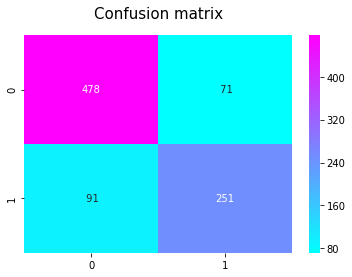

In [28]:
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.metrics import accuracy_score  #for accuracy_score


model = LogisticRegression()
model.fit(X_train,y_train)
prediction_lr=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_lr,y_test)*100,2))
result_lr=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_lr.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Accuracy 83.58
The cross validated score 83.16


Text(0.5,1.05,'Confusion matrix')

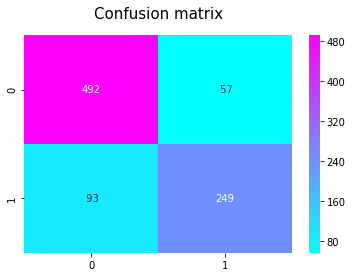

In [29]:
from sklearn.svm import SVC, LinearSVC

model = SVC()
model.fit(X_train,y_train)
prediction_svm=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_svm,y_test)*100,2))
result_svm=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_svm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Accuracy 80.97
The cross validated score 82.27


Text(0.5,1.05,'Confusion matrix')

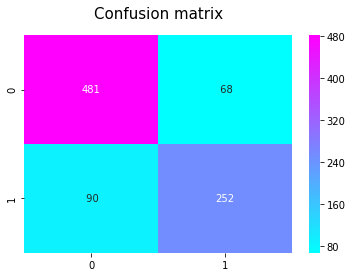

In [30]:
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train,y_train)
prediction_knn=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_knn,y_test)*100,2))
result_knn=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_knn.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Accuracy 76.87
The cross validated score 79.02


Text(0.5,1.05,'Confusion matrix')

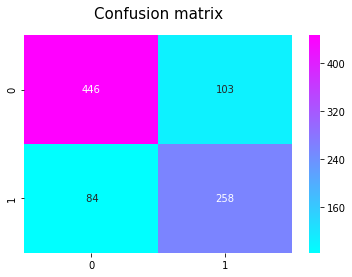

In [31]:
from sklearn.naive_bayes import GaussianNB
model= GaussianNB()
model.fit(X_train,y_train)
prediction_gnb=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_gnb,y_test)*100,2))
result_gnb=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_gnb.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Accuracy 79.48
The cross validated score 80.49


Text(0.5,1.05,'Confusion matrix')

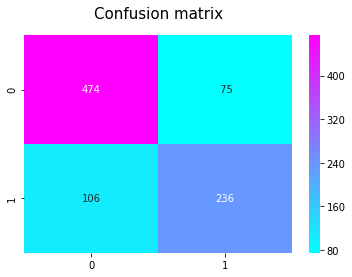

In [32]:
from sklearn.tree import DecisionTreeClassifier
model= DecisionTreeClassifier(criterion='gini', 
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto')
model.fit(X_train,y_train)
prediction_tree=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_tree,y_test)*100,2))
result_tree=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_tree.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Accuracy 80.97
The cross validated score 81.49


Text(0.5,1.05,'Confusion matrix')

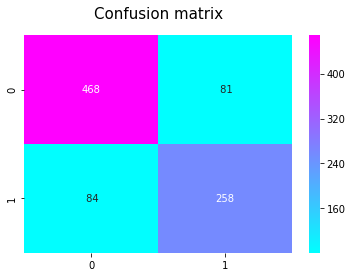

In [33]:
from sklearn.ensemble import AdaBoostClassifier
model= AdaBoostClassifier()
model.fit(X_train,y_train)
prediction_adb=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_adb,y_test)*100,2))
result_adb=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_adb.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Accuracy 82.84
The cross validated score 82.72


Text(0.5,1.05,'Confusion matrix')

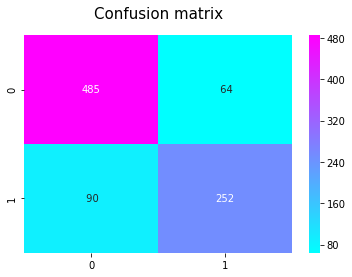

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model= LinearDiscriminantAnalysis()
model.fit(X_train,y_train)
prediction_lda=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_lda,y_test)*100,2))
result_lda=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_lda.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Accuracy 82.09
The cross validated score 84.29


Text(0.5,1.05,'Confusion matrix')

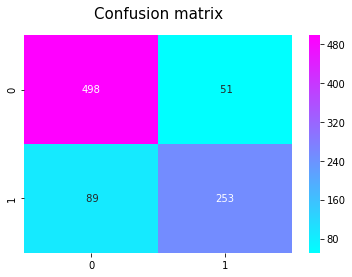

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier()
model.fit(X_train,y_train)
prediction_gbc=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_gbc,y_test)*100,2))
result_gbc=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_gbc.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Now we compare the tuned parameters and not the tuned ones

Accuracy 82.09
The cross validated score 84.06


Text(0.5,1.05,'Confusion matrix')

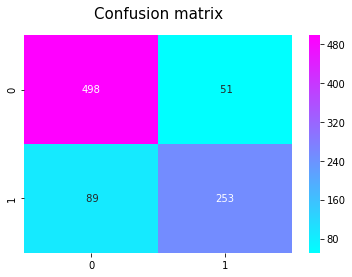

In [36]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
model_rf.fit(X_train,y_train)
prediction_rm=model.predict(X_test)


print('Accuracy',round(accuracy_score(prediction_rm,y_test)*100,2))
result_rm=cross_val_score(model_rf,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Accuracy 77.61
The cross validated score 84.06


Text(0.5,1.05,'Confusion matrix')

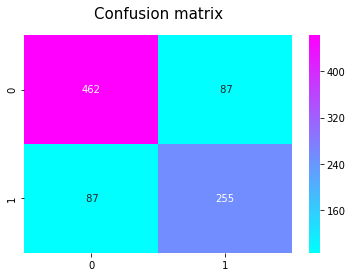

In [37]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model1.fit(X_train,y_train)

prediction_rm1=model1.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_rm1,y_test)*100,2))
result_rm1=cross_val_score(model1,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model1,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix', y=1.05, size=15)

Let us now put all of our results in one dataframe and compare the (cross-validated) accuracy.

In [38]:
models = pd.DataFrame({
    'Model': ["support vector machine",'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'AdaBoostClassifier', 
              'Gradient Decent', 'Linear Discriminant Analysis', 
              'Decision Tree',"Tuned RF"],
    'Score': [result_svm.mean(),result_knn.mean(), result_lr.mean(), 
              result_rm.mean(), result_gnb.mean(), result_adb.mean(), 
              result_gbc.mean(), result_lda.mean(), result_tree.mean(),result_rm1.mean()]})
models.sort_values(by='Score',ascending=False) #pd.DAtaFrame() is a function that takes a dictionary as an input. Within this list we determine key-values paires (column name-values within column)


,Model,Score
6,Gradient Decent,0.842892
3,Random Forest,0.840633
0,support vector machine,0.831644
7,Linear Discriminant Analysis,0.827175
1,KNN,0.822667
2,Logistic Regression,0.818249
5,AdaBoostClassifier,0.814877
9,Tuned RF,0.807000
8,Decision Tree,0.804865
4,Naive Bayes,0.790157


**NOTE** we need to differentiate two data sets here. First of all X_train etc... was created with sklearn in order to obtain accuracy scores. train_X etc. is basically original training data that we use to eventually give predictions. Why did we seperate it? Well our original test data did not include predictions, so we could not use it as hold-out set and test the accuracy. That is why we had to create our own

Good thing about randomForest model is that can be used as PCA, where we can select the most important features with a simple command line. That is important (and can confirm our intution) about what varibles predict the Survive column the best.

Now we use our best model to create output set (predictions!!!) Please note that here we are working with train_X etc. because that is exactly the original train set with 891 observations (a bit of difference)

In [39]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
random_forest.fit(train_X, train_Y)
Y_pred_rf = random_forest.predict(test_X)
random_forest.score(train_X,train_Y)
acc_random_forest = round(random_forest.score(train_X, train_Y) * 100, 2)
print(acc_random_forest)

98.2


Feature selection


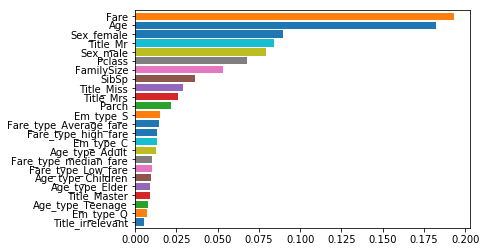

In [40]:


print("Feature selection")
pd.Series(random_forest.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8) #in a series x (theirs relative importance) and y values are taken


In [41]:


submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred_rf})

In [42]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [43]:
submission.to_csv('submission.csv', index=False)